In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

In [2]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
0,47,13,1,1.0,0,0,0,1,0,regular,NaN,0,1.3,1.16935,6347.577148,3.9,1
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
2,804,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
3,812,19,1,100.0,0,0,1,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
4,191,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,2,2,0,1,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32088,39339,23,6,100.0,3,3,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32089,24505,23,6,50.0,2,2,3,4,4,instant,NaN,0,0.7,0.00000,10627.522461,5.3,1
32090,100781,23,6,60.0,1,1,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0


In [3]:
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment'], drop_first=True, dtype=int)
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [4]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)

# Visualización datos después del escalador
display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
0,47,13,1,1.0,0,0,0,1,0,0,1.3,1.16935,6347.577148,3.9,1,1,0
1,99001309,14,0,100.0,0,1,0,0,0,1,1.3,1.18803,5630.115723,4.0,0,1,0
2,804,19,1,100.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
3,812,19,1,100.0,0,0,1,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
4,191,19,1,100.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
5,430,19,1,100.0,0,1,1,0,1,1,1.3,1.18800,5543.707520,4.0,1,1,0
6,761,19,1,99.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
7,735,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
8,406,19,1,100.0,0,0,1,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
9,140,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before
0,-0.296422,0.066732,-0.956470,-3.185956,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.641888,-1.966732,-2.926786,1.243453,-0.395245
1,3.386761,0.256384,-1.503384,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683855,-2.658549,-2.640847,1.243453,-0.395245
2,-0.296394,1.204643,-0.956470,0.636416,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
3,-0.296394,1.204643,-0.956470,0.636416,-0.868485,-1.047367,0.169725,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
4,-0.296417,1.204643,-0.956470,0.636416,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
5,-0.296408,1.204643,-0.956470,0.636416,-0.868485,-0.329742,0.169725,-0.527494,-0.042611,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
6,-0.296396,1.204643,-0.956470,0.597806,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
7,-0.296397,1.204643,-0.956470,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
8,-0.296409,1.204643,-0.956470,0.636416,-0.868485,-1.047367,0.169725,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
9,-0.296419,1.204643,-0.956470,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245


## PCA para practicar con este df_simpl

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [6]:
# Aplicación PCA a ver qué pasa con estos datos

X_scaled=normalizado
feature_names=X_log_L.columns


In [7]:
# Calcular la matriz de covarianza
cov_matrix = np.cov(X_scaled.T)

# Calcular los valores propios y los vectores propios
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

# Mostrar los valores propios y los vectores propios
print("Valores propios:", eig_values)
print("\nVectores propios:\n", eig_vectors)

Valores propios: [3.3211939  2.09696447 1.74708989 1.70421579 1.0301129  0.99061402
 0.94911486 0.85015327 0.78996767 0.67317018 0.5273483  0.35312543
 0.18832985 0.22265622 0.28795924 0.26848258]

Vectores propios:
 [[-1.29498400e-01  2.60924622e-03 -1.16550963e-01  9.65836408e-02
  -2.03358575e-02 -1.50257596e-01 -9.49726830e-01 -1.49343456e-01
   6.89596529e-02  2.70653095e-03  4.02916334e-02  7.05306770e-02
  -7.32756980e-04  5.60628001e-03 -4.04255607e-02  2.91076318e-03]
 [-2.42675307e-02 -1.71690720e-02  9.40497424e-03  6.08384711e-02
  -4.74121012e-01  8.60733963e-01 -1.32642496e-01  9.16478930e-02
   7.30105413e-03 -3.31360970e-02  2.31898311e-02 -3.58949464e-02
   1.48647394e-02  1.39944647e-02 -1.53601576e-02  7.01558338e-03]
 [ 4.77656629e-02  4.50987041e-02 -4.68598642e-01 -5.24839312e-01
  -7.74087298e-03  3.49305963e-02 -2.42926360e-03 -3.35550022e-03
   2.82683432e-02 -1.01746885e-02  9.70475846e-03  3.97291192e-02
   1.06091024e-01 -2.24485323e-02  6.19510248e-02  6.93

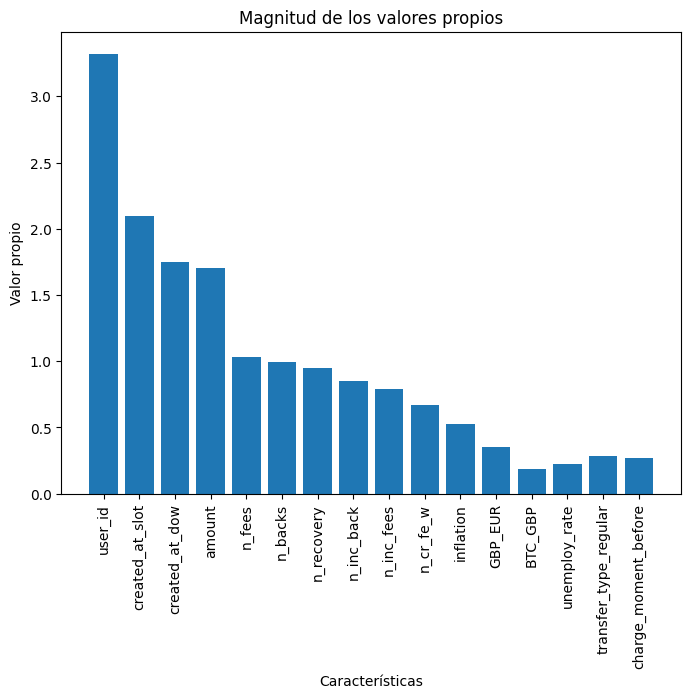

In [8]:
# Visualización de los valores propios (magnitud de varianza)
plt.figure(figsize=(8,6))
plt.bar(range(len(eig_values)), eig_values, tick_label=feature_names)
plt.xlabel('Características')
plt.ylabel('Valor propio')
plt.title('Magnitud de los valores propios')
plt.xticks(rotation=90)
plt.show()

In [9]:
print(feature_names)

Index(['user_id', 'created_at_slot', 'created_at_dow', 'amount', 'n_fees',
       'n_backs', 'n_recovery', 'n_inc_back', 'n_inc_fees', 'n_cr_fe_w',
       'inflation', 'GBP_EUR', 'BTC_GBP', 'unemploy_rate',
       'transfer_type_regular', 'charge_moment_before'],
      dtype='object')


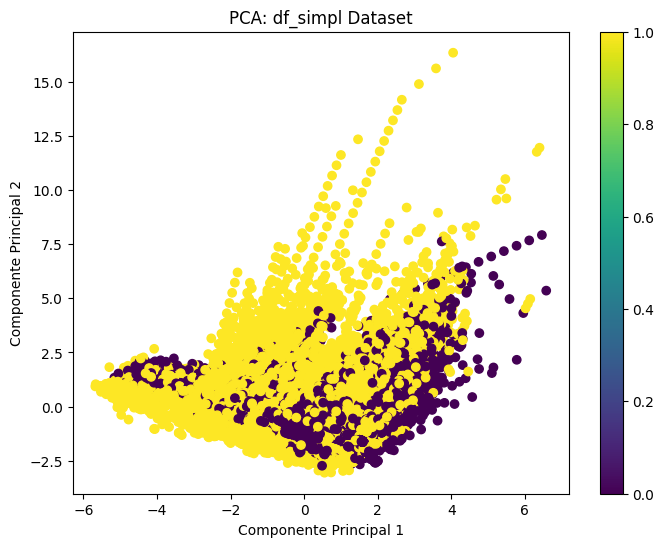

In [10]:
# Aplicar PCA
n_components = len(eig_values)
pca = PCA(n_components)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los resultados de PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA: df_simpl Dataset')
plt.colorbar(label='')
plt.show()

In [11]:
# Mostrar la varianza explicada por cada componente
print(f"Varianza explicada por los primeros dos componentes: {sum(pca.explained_variance_ratio_[0:2])}")

Varianza explicada por los primeros dos componentes: 0.33862434638986894


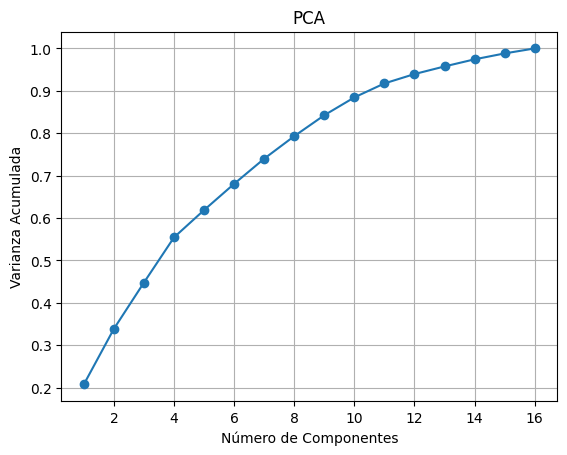

In [17]:
# Verificar cuántas componentes se necesitan para un buen nivel de varianza explicada

pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.title('PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()


Necesitamos 10 componentes para poder explicar el 90% (casi) de los datos. 

In [13]:
# Encontramos el número mínimo de componentes que explican al menos el 90% de la varianza
n_components_90 = (explained_variance.cumsum() >= 0.90).argmax() + 1  # `argmax` devuelve el primer índice donde la varianza acumulada es >= 0.90
print(f"Número de componentes para explicar el 90% de la varianza: {n_components_90}")

# Aplicamos PCA con ese número de componentes
pca_90 = PCA(n_components=n_components_90)
X_pca_90 = pca_90.fit_transform(X_scaled)

# Ahora `X_pca_90` contiene las nuevas características (componentes) que explican el 90% de la varianza
print(f"Tamaño del nuevo conjunto de datos con 90% de varianza explicada: {X_pca_90.shape}")

Número de componentes para explicar el 90% de la varianza: 11
Tamaño del nuevo conjunto de datos con 90% de varianza explicada: (32092, 11)


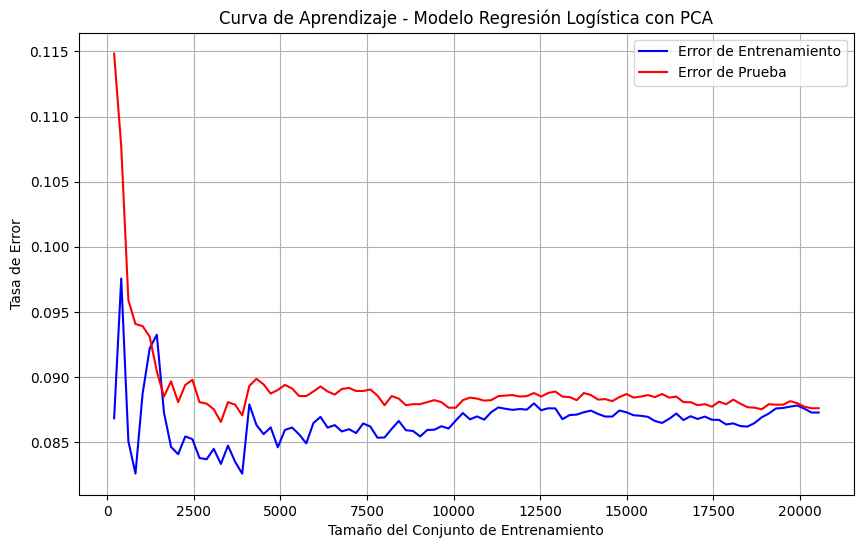

Precisión del modelo final en el conjunto de test: 0.9176


In [14]:
# Dividir los datos en train y test, usa X_pca_90 como características
X_train, X_test, y_train, y_test = train_test_split(X_pca_90, y, test_size=0.2, random_state=42)

# Inicializamos el modelo de regresión logística
clf = LogisticRegression(solver='liblinear', max_iter=1000)

# Obtener la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, train_sizes = np.linspace(0.01, 1.0, 100), cv=5, n_jobs=-1
)

# Calcular la tasa de error
train_errors = 1 - train_scores.mean(axis=1)
test_errors = 1 - test_scores.mean(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label="Error de Entrenamiento", color="blue")
plt.plot(train_sizes, test_errors, label="Error de Prueba", color="red")
plt.title('Curva de Aprendizaje - Modelo Regresión Logística con PCA')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Tasa de Error')
plt.legend()
plt.grid(True)
plt.show()

# Entrenar el modelo con el conjunto completo para obtener las predicciones finales
clf.fit(X_train, y_train)

# Evaluación final en el conjunto de test
test_accuracy = clf.score(X_test, y_test)
print(f'Precisión del modelo final en el conjunto de test: {test_accuracy:.4f}')

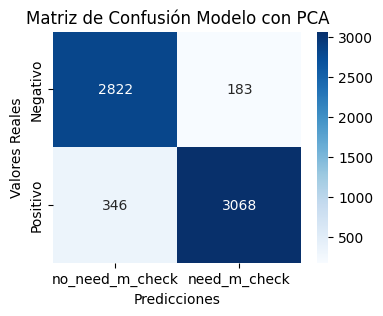

Accuracy: 0.9176


In [21]:
# Entrenar el modelo en el conjunto de entrenamiento completo
clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Mostrar la matriz de confusión como mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_need_m_check', 'need_m_check'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Modelo con PCA')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

# Imprimir métricas de desempeño
print(f"Accuracy: {accuracy:.4f}")


In [16]:
# Comprobación que estamos con las 11 caracteristicas q ha generado PCA para reducir dimensionalidad.
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)

Shape de X_train: (25673, 11)
Shape de X_test: (6419, 11)
